<a href="https://colab.research.google.com/github/Euler912/Breast-Cancer-Classification/blob/main/Machine_Learning_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Packages

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
bc=datasets.load_breast_cancer()
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold



#Preparing the Datasets

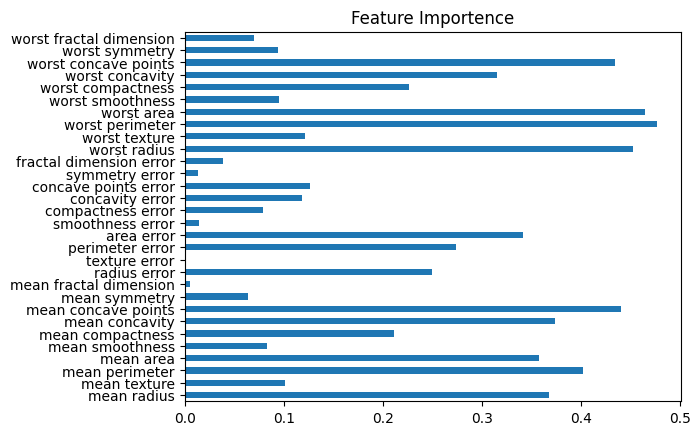

In [ ]:
X,y= bc.data ,bc.target
df = pd.DataFrame(data=bc.data, columns=bc.feature_names)
df2 = df.assign(target=bc.target)
X=df2.iloc[0:569,0:30]
Y=df2['target']
importances = mutual_info_classif(X, Y)
feat_importances=pd.Series(importances,df2.columns[0:len(df2.columns)-1])
feat_importances.plot(kind='barh')
plt.title("Feature Importence")
plt.show()
bc=df.drop(["worst fractal dimension", "worst symmetry","fractal dimension error","symmetry error","smoothness error","mean texture"], axis=1)
#print(bc.head(6))
X=bc.to_numpy()
y=Y.to_numpy()


In [ ]:
n_sample,n_features=X.shape
sc=StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)
X_val=sc.fit_transform(X_val)

X_val=torch.from_numpy(X_val.astype(np.float32))
X_train=torch.from_numpy(X_train.astype(np.float32))
X_test=torch.from_numpy(X_test.astype(np.float32))
y_train=torch.from_numpy(y_train.astype(np.float32))
y_test=torch.from_numpy(y_test.astype(np.float32))
y_val=torch.from_numpy(y_val.astype(np.float32))

y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)
y_val=y_val.view(y_val.shape[0],1)


#Logistic Regression

In [ ]:
class LogisticRegression(nn.Module):
     def __init__(self, n_input_features):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(n_input_features, 1)
     def forward(self, x):
       y_predicted= torch.sigmoid(self.linear(x))
       return y_predicted
model=LogisticRegression(n_features)



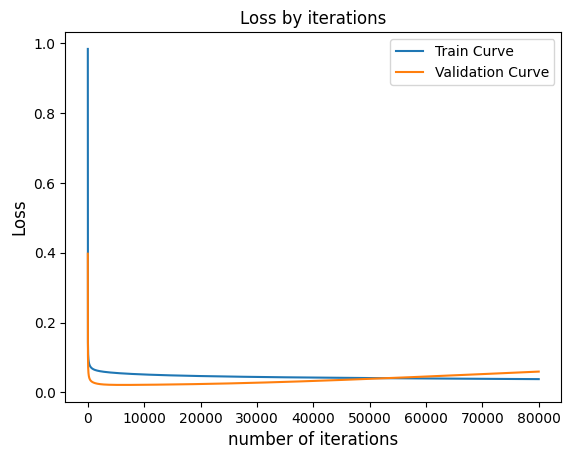

GPU time: 61.03442s


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = model.to(torch.device('cuda:0'))


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

iteration_number = 80000
model=LogisticRegression(n_features)
criterion=nn.BCELoss()
learning_rate=0.23
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

#The validation Curve
def val_curve():
  loss_train = []
  loss_val=[]

  for epoch in range(1, iteration_number+1):

      # Forward to get output
      results = model(X_train)

        # Calculate Loss
      loss = criterion(results, y_train)

        # backward propagation
      loss.backward()

        # Updating parameters
      optimizer.step()

        # optimization
      optimizer.zero_grad()

      # store loss
      loss_train.append(loss.data)

      with torch.no_grad():
        y_val_predictions = model(X_val)
        y_val_predictions_classes = y_val_predictions.round()
        loss_val.append(criterion(y_val_predictions,y_val))
        # loss_val = 0

  return loss_train, loss_val




alpha = np.linspace(1,iteration_number,iteration_number)
loss_train, loss_val = val_curve()

plt.plot(alpha, loss_train,label='Train Curve')
plt.plot(alpha, loss_val,label='Validation Curve')

plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Loss by iterations')
plt.show()
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds


epoch 0, loss 0.6855807900428772
epoch 50, loss 0.24651257693767548
epoch 100, loss 0.10645604878664017
epoch 150, loss 0.07819703966379166


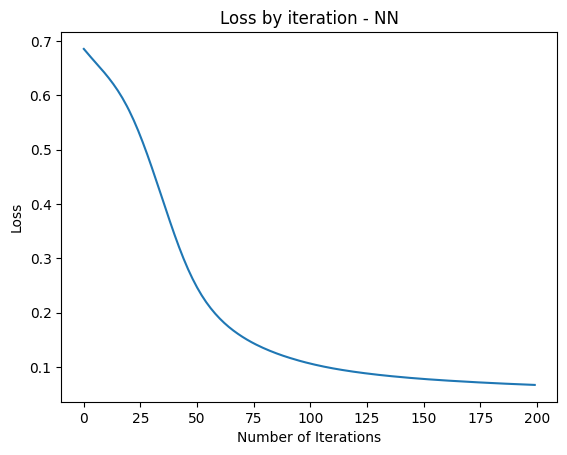

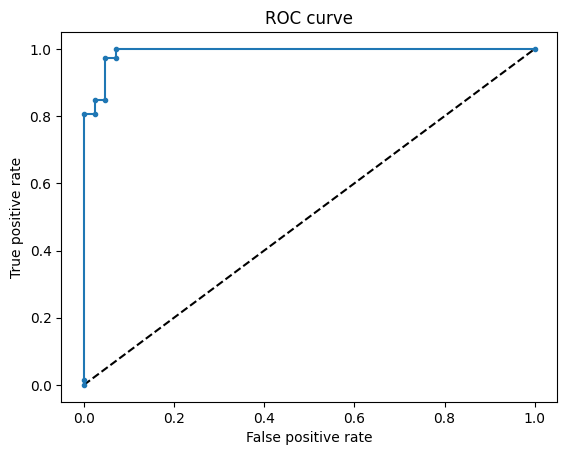

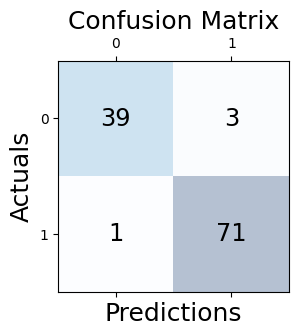

GPU time: 1.63947s


In [ ]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Initialize Timing ---
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

# --- Training Loop ---
model_NN = neural_classification(24, 10, 50, 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_NN.parameters(), lr=0.1)

loss_list = []
iteration_number = 200

# Start timing the training and evaluation process
start.record()

for iteration in range(iteration_number):
    model_NN.train()
    optimizer.zero_grad()

    y_prediction = model_NN(X_train.to(device))
    loss = criterion(y_prediction, y_train.to(device))

    loss.backward()
    optimizer.step()

    loss_list.append(loss.item()) # Use .item() for scalars
    if iteration % 50 == 0:
        print(f'epoch {iteration}, loss {loss.item()}')

# Plot Loss
plt.plot(range(iteration_number), loss_list)
plt.title("Loss by iteration - NN")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

# --- Evaluation (ROC & Optimal Threshold) ---
model_NN.eval()
with torch.no_grad():
    # 1. Get raw scores for ROC
    y_score_tensor = model_NN(X_test.to(device))
    y_score = y_score_tensor.cpu().numpy()

    # Ensure y_test is numpy for sklearn compatibility
    y_true = y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Plot ROC
plt.plot([0, 1], [0, 1], 'k--') # Changed to black dashed line 'k--' per request
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --- Finding Optimal Threshold ---
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits=4)

# --- Confusion Matrix ---
# Apply threshold to the numpy scores calculated during eval
y_pred_binary = (y_score > thresholdOpt).astype(int)

conf_matrix = confusion_matrix(y_true, y_pred_binary)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# --- Finalize Timing ---
end.record()
torch.cuda.synchronize() # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")


#tuning learning rate of logistic regression

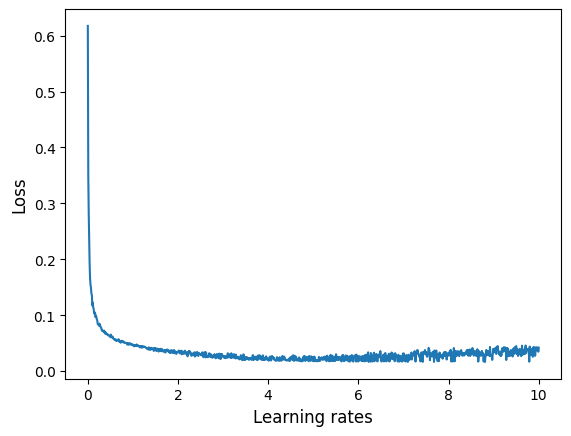

In [ ]:

import random
alpha=np.linspace(0.001,10,1000)
rows_idxs = list(range(X_train.shape[0]))
model=LogisticRegression(n_features)
def rate_tune():
  loss_history=[]
  epochs=40
  for learning_rate in alpha:
    model=LogisticRegression(n_features)
    optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
    for k in range(epochs):


        y_train_pred_probablity = model(X_train)

        # optimization
        optimizer.zero_grad()

      # Forward to get output
        results = model(X_train)

      # Calculate Loss
        loss = criterion(y_train_pred_probablity, y_train)

      # backward propagation
        loss.backward()

      # Updating parameters
        optimizer.step()


        optimizer.zero_grad()

      # # store loss
      # loss_history.append(loss.data)


    y_val_pred_probablity = model(X_val)
    loss_history.append(criterion(y_val_pred_probablity, y_val).item())
  return loss_history

rate_tune()
plt.plot(alpha, rate_tune())
plt.xlabel('Learning rates', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()


#Neural Networks

In [ ]:
class neural_classification(nn.Module):
  def __init__(self,input_size,hidden1_size,hidden2_size,num_classes):

    super(neural_classification,self).__init__()

    self.fc1=nn.Linear(input_size,hidden1_size)

    self.fc2=nn.Linear(hidden1_size,hidden2_size)

    self.fc3=nn.Linear(hidden2_size,num_classes)

  def forward(self,x):


      x= torch.relu(self.fc1(x))

      x= torch.relu(self.fc2(x))

      x=torch.sigmoid(self.fc3(x))

      return x


epoch 0, loss 0.6937777400016785
epoch 50, loss 0.18060745298862457
epoch 100, loss 0.097486712038517
epoch 150, loss 0.07604480534791946


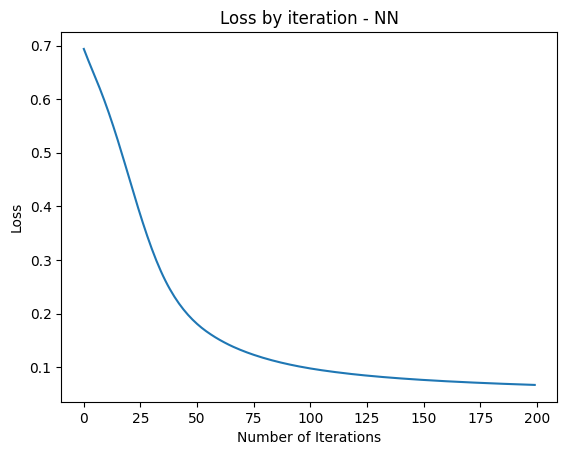

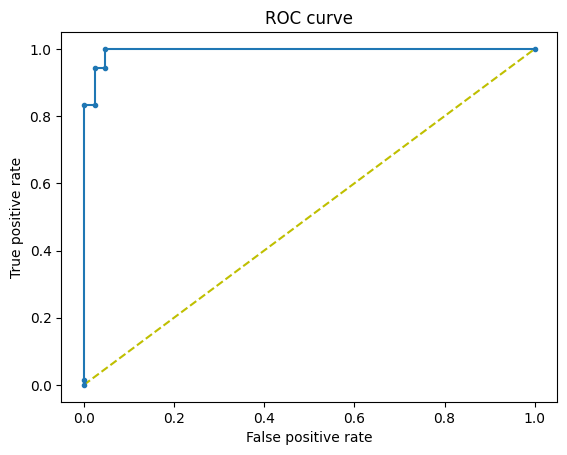

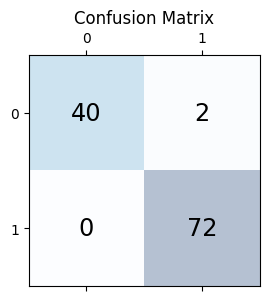

In [ ]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Training Loop ---
model_NN = neural_classification(24, 10, 50, 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_NN.parameters(), lr=0.1)

loss_list = []
iteration_number = 200

for iteration in range(iteration_number):
    model_NN.train()
    optimizer.zero_grad()

    y_prediction = model_NN(X_train.to(device))
    loss = criterion(y_prediction, y_train.to(device))

    loss.backward()
    optimizer.step()

    loss_list.append(loss.item()) # Use .item() for scalars
    if iteration % 50 == 0:
        print(f'epoch {iteration}, loss {loss.item()}')

# Plot Loss
plt.plot(range(iteration_number), loss_list)
plt.title("Loss by iteration - NN")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

# --- Evaluation (ROC & Optimal Threshold) ---
model_NN.eval()
with torch.no_grad():
    # 1. Get raw scores for ROC
    y_score_tensor = model_NN(X_test.to(device))
    y_score = y_score_tensor.cpu().numpy()

    # Ensure y_test is numpy
    y_true = y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Plot ROC
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --- Finding Optimal Threshold ---
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits=4)

# --- Confusion Matrix ---
# Apply threshold to the numpy scores we already calculated
y_pred_binary = (y_score > thresholdOpt).astype(int)

conf_matrix = confusion_matrix(y_true, y_pred_binary)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.title("Confusion Matrix")
plt.show()
